# Prepare_datasets.py

importing libraries for making datasets

In [1]:
import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       
import os                                                                           
import random 
import json

import cv2                                                                         
import mediapipe as mp  

from torch.utils.data import Dataset
from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm                                                         
from collections import Counter
from typing import Callable, List
from sklearn.model_selection import train_test_split   

function to get landmarks from LSA64

In [2]:
def get_landmarks_LSA64(root: str,
                        class_names: List[str],
                        frame_numbers: int):
    
    all_video_paths= natsorted([str(p) for p in Path(root).glob("**/*.mp4")])
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    none_cv2_video_paths= []
    detections= []
    labels= []
    frame_numbers= frame_numbers
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        for video_path in tqdm(all_video_paths, desc="Processing videos"):
            cap = cv2.VideoCapture(video_path)              # Read each video using cv2
            if not cap.isOpened():                          # if cv2 can't read the video
                none_cv2_video_paths.append(video_path)     # save the video path
            else:                                           # if cap can read the video
                total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                # getting the total frames in video
                frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)     # picking desiered frame indexes
                video_detections= []
                for idx in frame_idxs_to_process:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ret, frame= cap.read()
            
                    result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                    face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                    lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                    rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                    detection= np.concatenate((pose,face,lh, rh))
                    label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                    video_detections.append(detection)

                
                detections.append(video_detections)    
                label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])] # gets the label for the videos
                labels.append(label)
   
            cap.release()
        
    return detections, labels, len(all_video_paths),len(none_cv2_video_paths)

functions for getting landmarks from WLASL 100

In [3]:
def process_frame(cap, index):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    return cap.read() 

def get_landmarks_WLASL100(root: str,
                           class_names: List[str],
                           frame_numbers: int = 25):
    
    all_video_paths= natsorted([str(p) for p in Path(root).glob("**/*.mp4")])
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    none_cv2_video_paths= []                                # keeping track of corrupt video files
    detections= []                                          # saves mediapipe detections
    labels= []
    
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        for video_path in tqdm(all_video_paths, desc="Processing videos"):
            cap = cv2.VideoCapture(video_path)              # Read each video using cv2
            if not cap.isOpened():                          # if cv2 can't read the video
                none_cv2_video_paths.append(video_path)     # save the video path
                continue
                
            total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                             # getting the total frames in video
            frame_idxs_to_process = np.round(np.linspace(0, total_frames_number - 1, frame_numbers)).astype(int)     # picking desiered frame indexes
            video_detections= []
            for idx in frame_idxs_to_process:
                ret, frame= process_frame(cap, idx)

                if ret is False:
                    # if the return value is False: meaning the frame was "bad".
                    print(f"Failed to grab frame {idx}, of video {video_path} of length {total_frames_number} frames. trying adjacent frames...")

                    # we try to read the previous frame.
                    ret, frame = grab_frame(cap, idx - 1)
                    if not ret:
                        # if the return value is False: meaning previous frame was also "bad".
                        # we try to read the next frame with cv2.
                        ret, frame = grab_frame(cap, idx + 1)
                        
                if not ret:
                    # if the return value is False.
                    print(f"Unable to retrieve any frames around index {idx}, of video {video_path} of length {total_frames_number} frames.")
                    # we add empty detection that will be filled using interpolation
                    detection= []
                    video_detections.append(detection)
                    continue
                            
                result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                detection= np.concatenate((pose,face,lh, rh))
                video_detections.append(detection)

                
            detections.append(video_detections)    
            label= vid_idx_to_class_name[int(os.path.basename(os.path.dirname(video_path)))]
            labels.append(label)
   
        cap.release()
        
    return detections, labels, len(all_video_paths),len(none_cv2_video_paths)

functions to interpolate incase frames are damaged in WLASL

In [4]:
def interpolate_frames(most_recent_detection, next_coming_detection, alpha):
    if most_recent_detection is None and next_coming_detection is not None:             # first to nth frames are all corrupt
        return next_coming_detection
    elif most_recent_detection is not None and next_coming_detection is None:           # nth to last frames are all corrupt
        return most_recent_detection
    else:
        return (1 - alpha) * most_recent_detection + alpha * next_coming_detection 

In [5]:
def fill_empty_detections(result):
    detections= result
    for video_detection in detections:
        most_recent_detection= None
        for i in range(len(video_detection)):
            if len(video_detection[i]) != 0:
                most_recent_detection= video_detection[i]
            else:
                next_coming_detection= None
                for j in range(i+1, len(video_detection)):
                    if len(video_detection[j]) != 0:
                        next_coming_detection= video_detection[j]
                        break
                    else:
                        continue
                     
                video_detection[i]= interpolate_frames(most_recent_detection, next_coming_detection, 0.5)
                most_recent_detection= video_detection[i]

    return detections

# Preprocessing.py

importing libraries for preprocessing

In [6]:
import numpy as np                                                                  
import pandas as pd
import matplotlib.pyplot as plt                                                       
import os                                                                           
import random 
import json

import cv2                                                                         
import mediapipe as mp  

from torch.utils.data import Dataset
from glob import glob                                                               
from pathlib import Path                                                            
from natsort import natsorted                                                       
from tqdm.auto import tqdm                                                         
from collections import Counter
from collections import defaultdict
from typing import Callable, List, Tuple
from sklearn.model_selection import train_test_split
from numpy.typing import NDArray

In [7]:
def interpolate_video_detections(vd1: NDArray[np.float64], 
                                 vd2: NDArray[np.float64], 
                                 shapes: List[Tuple[int, int]],
                                 alpha: float):
    
    num_frames = vd1.shape[0]
    ivd= np.zeros_like(vd1)
    for i in range(num_frames):
        fd1= vd1[i]
        fd2= vd2[i]
        ifd= np.zeros_like(fd1)
        for (start, end) in shapes:
            fd1part= fd1[start:end]
            fd2part= fd2[start:end]
            if np.all(fd1part == 0) and np.all(fd2part == 0):                   #both pose, face, lh, rh set of landmarks are 0 or not detected
                ivd[i][start:end] = np.zeros(end- start)  
            elif np.all(fd1part == 0):                                            # only in frame of video 1 is not detected
                ivd[i][start:end] = fd2part  
            elif np.all(fd2part == 0):
                ivd[i][start:end] = fd1part 
            else:
                #ivd[i][start:end]= (1 - alpha) * fd1part + alpha * fd2part
                A = fd1part+ ((fd1part + fd2part) / 2)**2 - (fd1part)**2 + ((fd1part + fd2part) / 2)**2 - (fd2part)**2  # Interpolate normally
                B = fd1part+ ((fd1part + fd2part) / 2)**2 - (fd1part)**2 + ((fd1part + fd2part) / 2)**2 - (fd2part)**2 
                ivd[i][start:end]= (1 - alpha) * A + alpha * B
    return ivd

In [8]:
def interpolate_dataset(detections: NDArray[np.float64],
                        labels: List[str],
                        alpha: float= 0.5,
                        min_interpolations: int= 5):
    data= defaultdict(list)                         # stores current data
    interpolated_data= defaultdict(list)            # stores interpolated data
    augumented_data = defaultdict(list)             # union of current and interpolated
    detection_shape= [(0, 132), (132, 1536), (1536, 1599), (1599, 1662)]
    
    x = []                                          # used to unpack augumented_data
    y = []

    for idx, label in enumerate(labels):
        data[label].append(detections[idx])

    for label, detections in data.items():
        pairs= []
        for i in range(len(detections)):
            for j in range(i+1, len(detections)):
                pairs.append((i, j))
        selected_pairs = random.sample(pairs, min(min_interpolations, len(pairs)))
        for (i, j) in selected_pairs:
            ivd = interpolate_video_detections(detections[i], detections[j], detection_shape,alpha)
            interpolated_data[label].append(ivd)

    for d in (data, interpolated_data):
        for label, detections in d.items():
            augumented_data[label].extend(detections)

    for label, detections in augumented_data.items():
        for detection in detections:
            x.append(detection)
            y.append(label)

    return np.array(x), y

In [9]:
def draw_landmarks(frame: np.ndarray,
                   detection: NDArray[np.float64],
                   structure: List[int]):
    
    idx = 0
    while idx < len(detection):
        for coordinates in structure:
            if idx + coordinates > len(detection):
                break  

            x, y = detection[idx], detection[idx + 1]

            px = int(x * frame.shape[1])
            py = int(y * frame.shape[0])
            cv2.circle(frame, (px, py), 3, (0, 255, 0), -1)

            idx += coordinates
            if idx >= len(detection):
                break
    return frame

In [10]:
def show_detections(vd: NDArray[np.float64]):
    structure= [4]*33 + [3]*(468 + 21 + 21)  
    height= 720
    width= 1280
    cv2.namedWindow("Landmark Preview", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Landmark Preview", width= width, height= height)
    try:
        for idx, detection in enumerate(vd):
            frame = np.zeros((height, width, 3), dtype=np.uint8)
            frame = draw_landmarks(frame, detection, structure)
            cv2.imshow("Landmark Preview", frame)
            if cv2.waitKey(100) & 0xFF == 27:  #ESC key
                break
            #print(f"Displaying frame {idx + 1}/{len(vd)}")
    finally:
        cv2.destroyAllWindows()

In [33]:
def split_dataset(detections: NDArray[np.float64],
                  labels: List[str],
                  class_names: List[str],
                  test_size: float,
                  random_state: int):
    label_map= {label: num for num, label in enumerate(class_names)}
    
    X_train, X_test, y_train, y_test = train_test_split(detections, labels, test_size=0.2, random_state=42, stratify=labels)
    X_train, X_test= torch.tensor(X_train, dtype=torch.float32) , torch.tensor(X_test, dtype=torch.float32)
    
    y_train= [label_map[label] for label in y_train]
    y_test= [label_map[label] for label in y_test]
    y_train= torch.tensor(y_train, dtype=torch.long)
    y_test= torch.tensor(y_test, dtype=torch.long)
    
    return X_train, X_test, y_train, y_test

In [12]:
class CustomDataset(Dataset):
    def __init__(self,features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

# Train.py

import libraries for the functions

In [13]:
import torch
import torch.optim as optim                                                          
import torch.nn.functional as F 
import seaborn as sns

from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader     
from typing import Callable, List
from sklearn.metrics import confusion_matrix

In [14]:
def accuracy_fn(y_logits: torch.Tensor, y: torch.Tensor):
    y_preds= torch.argmax(y_logits, 1)
    corrects= (y_preds==y)
    accuracy= corrects.sum().item()/ corrects.size(0)
    return accuracy

In [15]:
def train(num_epochs: int,
          model: torch.nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          accuracy_fn: Callable[[torch.Tensor, torch.Tensor], torch.Tensor],
          device: torch.device):
    
    train_losses= []          # stores avg train losses of epoch
    test_losses= []           # stores avg test losses of epoch 
    train_accuracies= []      # stores avg train acc of epoch
    test_accuracies= []       # # stores avg test acc of epoch 
 
    for epoch in tqdm(range(num_epochs), desc="Training Epoch"):
        model.train()
        train_loss= [] # stores avg loss of batch
        train_acc= []  # stores avg acc of batch

        for X, y in train_dataloader:
            X= X.to(device) 
            y= y.to(device)
            
            optimizer.zero_grad()
            y_logits = model(X)
            loss = loss_fn(y_logits, y)        # loss of the batch
            loss.backward()
            optimizer.step()

            accuracy= accuracy_fn(y_logits, y) # accuracy of the batch
            
            train_loss.append(loss.item())
            train_acc.append(accuracy)
        
        train_losses.append(sum(train_loss) / len(train_loss))
        train_accuracies.append(sum(train_acc) / len(train_acc))
    
        model.eval()

        y_trues= []       # stores all the true labels for conf matrix
        y_preds= []       # stores all the predictions for conf matrix
        test_loss= []       # avg batch loss in test data per epoch
        test_acc= []        # avg batch acc in test data per epoch
        
        with torch.no_grad():
            for X, y in test_dataloader:
                X = X.to(device)
                y = y.to(device)
                
                y_logits = model(X)
                loss = loss_fn(y_logits, y)
                accuracy= accuracy_fn(y_logits, y)
                
                test_loss.append(loss.item())
                test_acc.append(accuracy)
                y_pred= torch.argmax(y_logits, 1)                  # predicted labels
                
                y_trues.extend(y.view(-1).cpu().numpy())           # Store true labels
                y_preds.extend(y_pred.view(-1).cpu().numpy())     # Store predictions
                
        
        test_losses.append(sum(test_loss) / len(test_loss))
        test_accuracies.append(sum(test_acc) / len(test_acc))

    return train_losses, test_losses, train_accuracies, test_accuracies, y_trues, y_preds

In [57]:
def plot_loss_accuracy(train_losses: List[float],
                       test_losses: List[float],
                       train_accuracies: List[float],
                       test_accuracies: List[float],
                       batch_size: int):
    
    plt.figure(figsize=(18, 9))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')  
    plt.plot(test_losses, label='Test Loss')
    plt.title(f'Loss over Epochs(batch size= {batch_size}), Last Loss:{test_losses[-1]}, ')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.title(f'Accuracy over Epochs(batch size= {batch_size}), Last Accuracy: {test_accuracies[-1]}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [49]:
def plot_confusion_matrix(y_trues: List[int],
                          y_preds: List[int],
                          class_names: List[str],
                          num_epochs: int):
    conf_matrix = confusion_matrix(y_trues, y_preds)
    plt.figure(figsize=(18, 15))
    
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted classes')
    plt.ylabel('Actual classes')
    
    plt.title(f'Confusion Matrix after {num_epochs} epoches')
    plt.show()

In [52]:
def set_train_parameters(detections: NDArray[np.float64], 
                         labels: List[str],
                         class_names: List[str],
                         test_size: float,
                         random_state: int,
                         batch_size: int,
                         num_epochs: int,
                         model: torch.nn.Module,
                         learning_rate: float,
                         device: torch.device):
    
    xtrain, xtest, ytrain, ytest= split_dataset(detections, labels, class_names, test_size, random_state)
    train_dataset= CustomDataset(xtrain, ytrain)
    test_dataset= CustomDataset(xtest, ytest)
    train_dataloader = DataLoader(dataset=train_dataset, batch_size= batch_size, num_workers=0, shuffle=True) 
    test_dataloader = DataLoader(dataset=test_dataset, batch_size= batch_size, num_workers=0, shuffle=False) 
    
    model= model.to(device)                  
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)
    
    train_losses, test_losses, train_accuracies, test_accuracies, y_trues, y_preds = train(num_epochs, model, train_dataloader, test_dataloader, optimizer, loss_fn, accuracy_fn, device)
    plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, batch_size)
    plot_confusion_matrix(y_trues, y_preds, class_names, num_epochs)

# Models.py

import libraries for the models

In [18]:
import torch
from torch import nn
from typing import List

In [19]:
class ParamTransformer(nn.Module):
    def __init__(self,
                 class_names: List[str],
                 seq_len: int= 40, 
                 d_model: int= 1662,
                 nhead: int= 6,
                 d_ff: int=2048,
                 num_layers: int= 2):

        super().__init__()
        self.model_type = 'Transformer model with learable parameter for positional encoding'
        self.class_names= class_names
        self.positional_encoding= nn.Parameter(torch.randn(1, seq_len, d_model))
        self.encoder_layer = nn.TransformerEncoderLayer(d_model= d_model, nhead= nhead, dim_feedforward= d_ff, batch_first= True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer= self.encoder_layer, num_layers= num_layers)
        self.classifier = nn.Linear(in_features= d_model, out_features= len(self.class_names))


    def forward(self, src: torch.Tensor):
        """
        Args:
            src: Tensor of shape ``[batch_size, seq_len, input_shape]``
        Returns:
            output: Tensor of shape ``[batch_size, len(class_names)]``
        """
        output = src+ self.positional_encoding
        output = self.transformer_encoder(output)
        output = self.classifier(output[:,-1,:])

        return output

In [20]:
class LinearParamTransformer(nn.Module):
    def __init__(self,
                 class_names: List[str],
                 seq_len: int= 40, 
                 d_model: int= 128,
                 nhead: int= 4,
                 d_ff: int=2048,
                 num_layers: int= 2,
                 input_shape: int= 1662):
 
        super().__init__()
        self.model_type = 'Transformer model with linear layer and learnable parameter for positional encoding'
        
        self.class_names= class_names
        self.positional_encoding= nn.Parameter(torch.randn(1, seq_len, d_model))
        self.linear= nn.Linear(in_features= input_shape, out_features= d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model= d_model, nhead= nhead, dim_feedforward= d_ff, batch_first= True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer= self.encoder_layer, num_layers= num_layers)
        self.classifier = nn.Linear(in_features= d_model, out_features= len(self.class_names))


    def forward(self, src: torch.Tensor):
        """
        Args:
            src: Tensor of shape ``[batch_size, seq_len, input_shape]``
        Returns:
            output: Tensor of shape ``[batch_size, len(class_names)]``
        """
        output = self.linear(src)
        output= output+ self.positional_encoding
        output = self.transformer_encoder(output)
        output = self.classifier(output[:,-1,:])

        return output

In [42]:
class ConvoTransformer(nn.Module):
    def __init__(self,
                 class_names: List[str],
                 seq_len: int= 40, 
                 d_model: int= 128,
                 nhead: int= 4,
                 d_ff: int=2048,
                 num_layers: int= 2,
                 input_shape: int= 1662,
                 kernel_size: int= 1):

        super().__init__()
        self.model_type = 'Transformer model with convolutional layer for positional encoding'
        self.class_names= class_names
        self.positional_encoding= nn.Conv1d(in_channels= input_shape, out_channels= d_model, kernel_size= kernel_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model= d_model, nhead= nhead, dim_feedforward= d_ff, batch_first= True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer= self.encoder_layer, num_layers= num_layers)
        self.classifier = nn.Linear(in_features= d_model, out_features= len(self.class_names))


    def forward(self, src: torch.Tensor):
        """
        Args:
            src: Tensor of shape ``[batch_size, seq_len, input_shape]``
        Returns:
            output: Tensor of shape ``[batch_size, len(class_names)]``
        """
        src= src.permute(0, 2, 1)
        output = self.positional_encoding(src)
        output = output.permute(0, 2, 1)
        output = self.transformer_encoder(output)
        output = self.classifier(output[:,-1,:])
        return output

In [22]:
class Transformer(nn.Module):
    def __init__(self,
                 class_names: List[str],
                 seq_len: int= 40, 
                 d_model: int= 1662,
                 nhead: int= 6,
                 d_ff: int=2048,
                 num_layers: int= 2):

        super().__init__()
        self.model_type = 'Transformer model without any positional encoding'
        self.class_names= class_names
        self.encoder_layer = nn.TransformerEncoderLayer(d_model= d_model, nhead= nhead, dim_feedforward= d_ff, batch_first= True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer= self.encoder_layer, num_layers= num_layers)
        self.classifier = nn.Linear(in_features= d_model, out_features= len(self.class_names))


    def forward(self, src: torch.Tensor):
        """
        Args:
            src: Tensor of shape ``[batch_size, seq_len, input_shape]``
        Returns:
            output: Tensor of shape ``[batch_size, len(class_names)]``
        """
        output = self.transformer_encoder(src)
        output = self.classifier(output[:,-1,:])

        return output

In [54]:
class LstmModel(nn.Module):
    def __init__(self,
                 class_names: List[str],
                 input_size: int= 1662,
                 hidden_size: int= 277,
                 num_layers: int= 1):
        super().__init__()
        self.num_layers = num_layers
        self.class_names= class_names
        self.lstm_layers= nn.ModuleList()

        self.lstm_layers.append(nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True))
        for _ in range(1, num_layers):
            self.lstm_layers.append(nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, batch_first=True))
        
        self.fc = nn.Linear(in_features= hidden_size, out_features= len(self.class_names))
        self.relu = nn.ReLU()

    def forward(self, src):
        """
        Args:
            src: Tensor of shape ``[batch_size, seq_len, input_shape]``
            
        Returns:
            output: Tensor of shape ``[batch_size, len(class_names)]``
        """
        output = src
        for lstm in self.lstm_layers:
            output, _ = lstm(output)
            output = self.relu(output)

        output= self.fc(output[:,-1,:])
        return output

# Experiment.ipynb

In [31]:
wlasl100class_names= ["accident", "africa", "all", "apple", "basketball", "bed", "before", "bird", "birthday",
                      "black", "blue", "bowling", "brown", "but", "can", "candy", "chair", "change", "cheat", "city",
                      "clothes", "color", "computer", "cook", "cool", "corn", "cousin", "cow", "dance", "dark",
                      "deaf", "decide", "doctor", "dog", "drink", "eat", "enjoy", "family", "fine", "finish",
                      "fish", "forget", "full", "give", "go", "graduate", "hat", "hearing", "help", "hot",
                      "how", "jacket", "kiss", "language", "last", "letter", "like", "man", "many", "meet",
                      "mother", "need", "no", "now", "orange", "paint", "paper", "pink", "pizza", "play",
                      "pull", "purple", "right", "same", "school", "secretary", "shirt", "short", "son", "study",
                      "table", "tall", "tell", "thanksgiving", "thin", "thursday", "time", "walk", "want", "what",
                      "white", "who", "woman", "work", "wrong", "year", "yes", "book", "later", "medicine"]

lsa64class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
                   'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
                   'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
                   'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
                   'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
                   'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
                   'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
                   'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

wlaslsavedir= 'WLASLdataset_100/WLASL100_results/'
lsasavedir= 'lsa64_raw/all_results/'

getting all the data and labels

In [39]:
wlasl= np.load(os.path.join(wlaslsavedir, 'detections.npy'), allow_pickle=True)
with open(os.path.join(wlaslsavedir, 'labels.json'), 'r') as file:
    wlasl_lablels= json.load(file)

lsa30fps= np.load(os.path.join(lsasavedir, 'detections.npy'), allow_pickle=True)
with open(os.path.join(lsasavedir, 'labels.json'), 'r') as file:
    lsa30fps_labels= json.load(file)

lsa40fps= np.load(os.path.join(lsasavedir, 'detections40fps.npy'), allow_pickle=True)
with open(os.path.join(lsasavedir, 'labels40fps.json'), 'r') as file:
    lsa40fps_labels= json.load(file)

lsa50fps= np.load(os.path.join(lsasavedir, 'detections50fps.npy'), allow_pickle=True)
with open(os.path.join(lsasavedir, 'labels50fps.json'), 'r') as file:
    lsa50fps_labels= json.load(file)

lsa60fps= np.load(os.path.join(lsasavedir, 'detections60fps.npy'), allow_pickle=True)
with open(os.path.join(lsasavedir, 'labels60fps.json'), 'r') as file:
    lsa60fps_labels= json.load(file)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

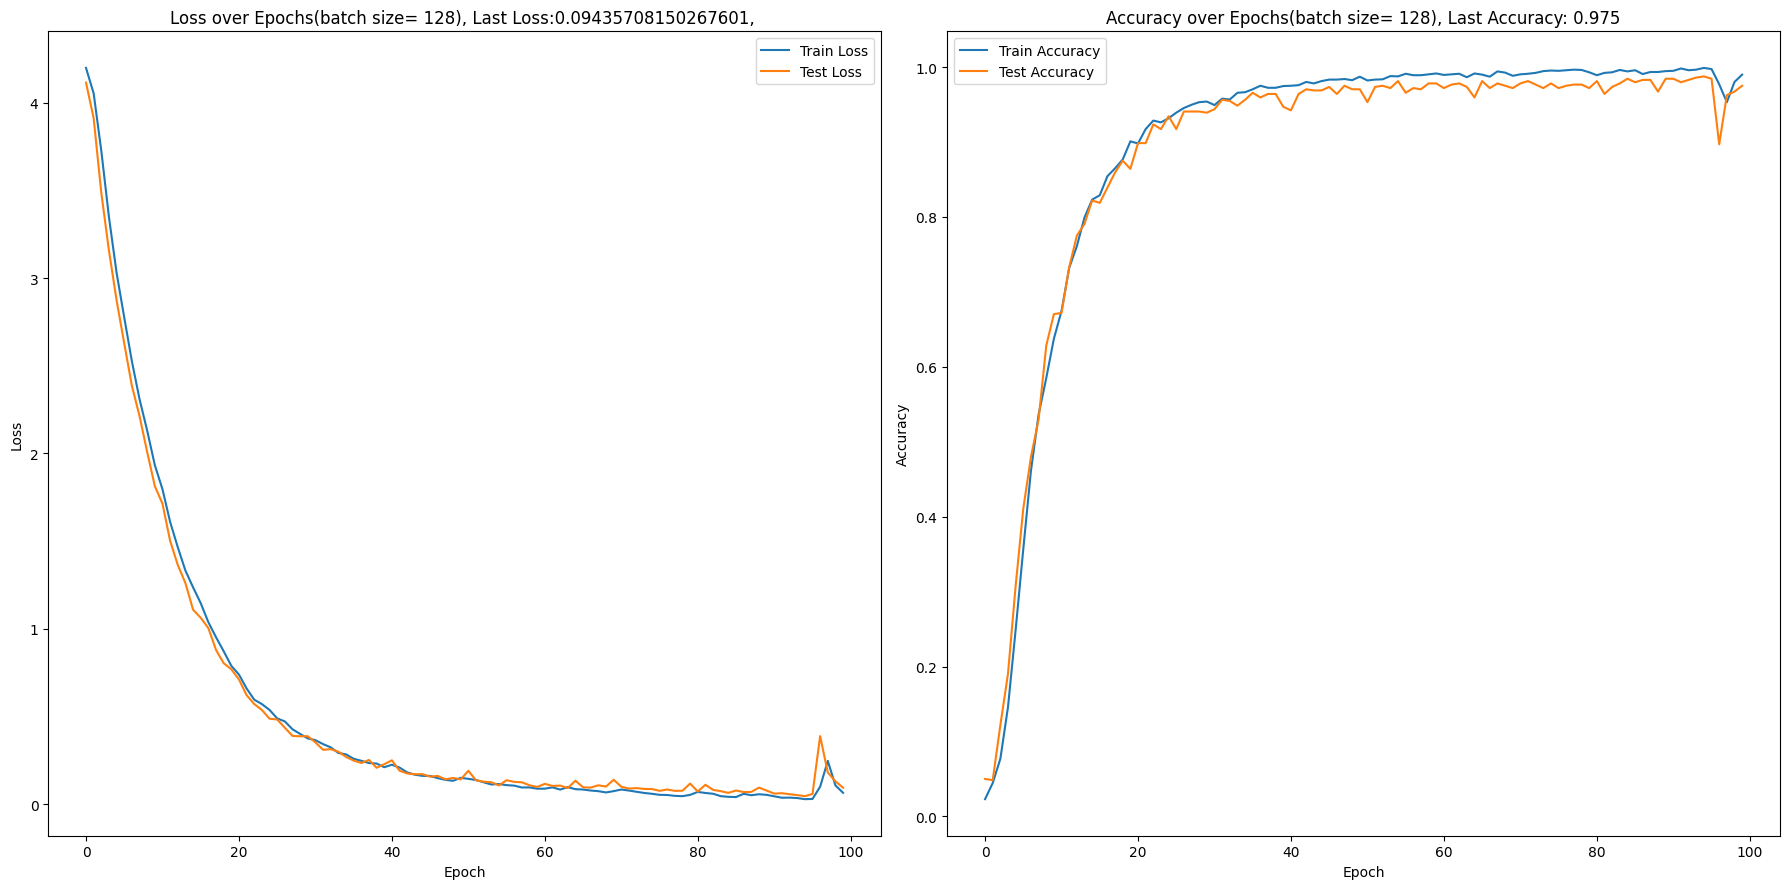

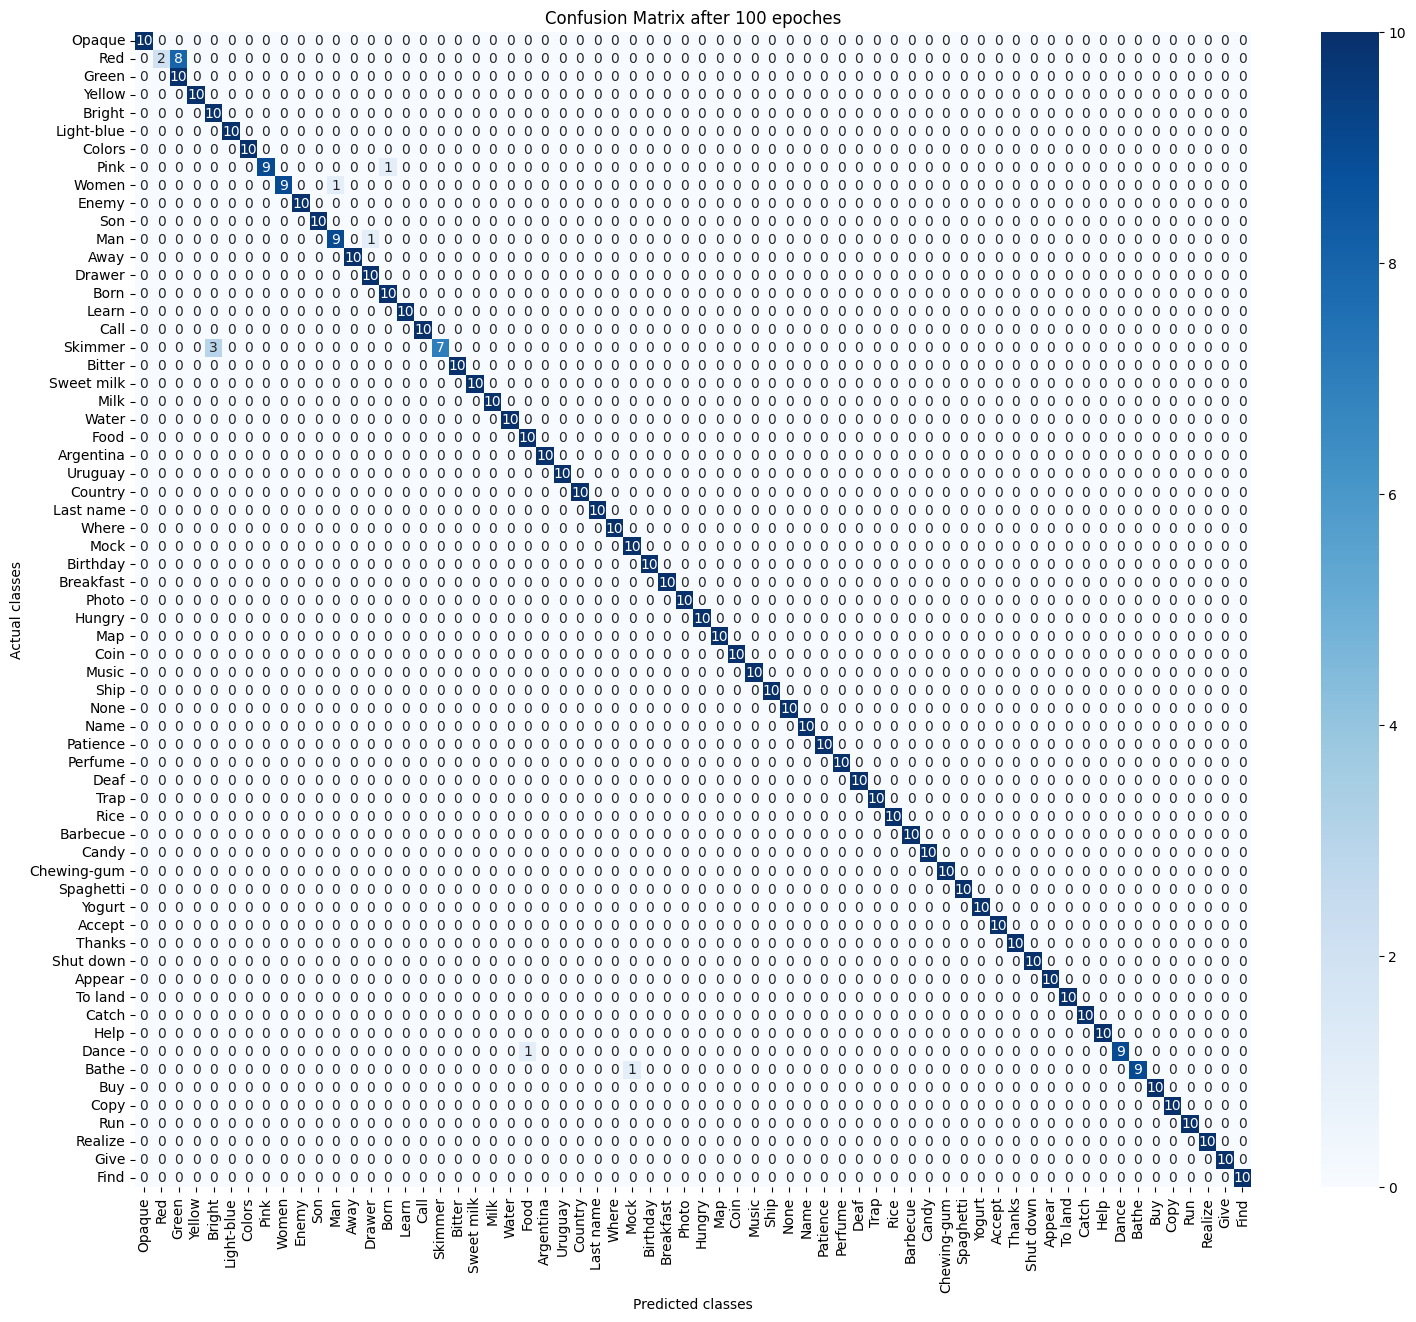

In [58]:
model= ConvoTransformer(lsa64class_names, 40, 128, 4, 2048, 2, 1662, 1)
set_train_parameters(lsa40fps, lsa40fps_labels, lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

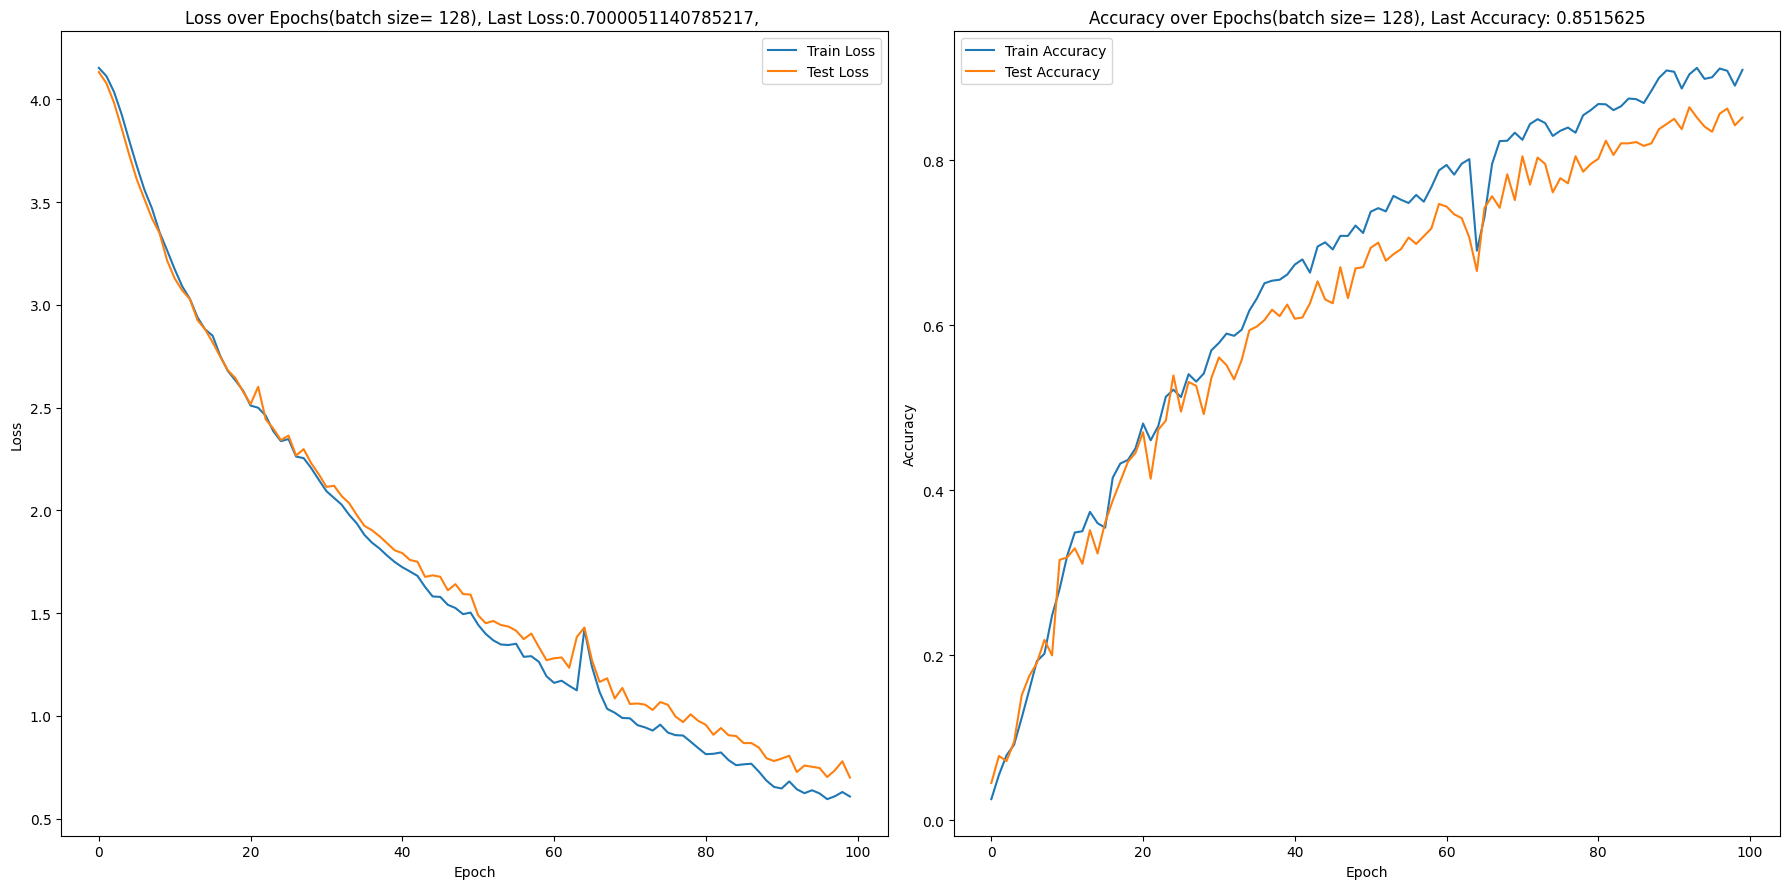

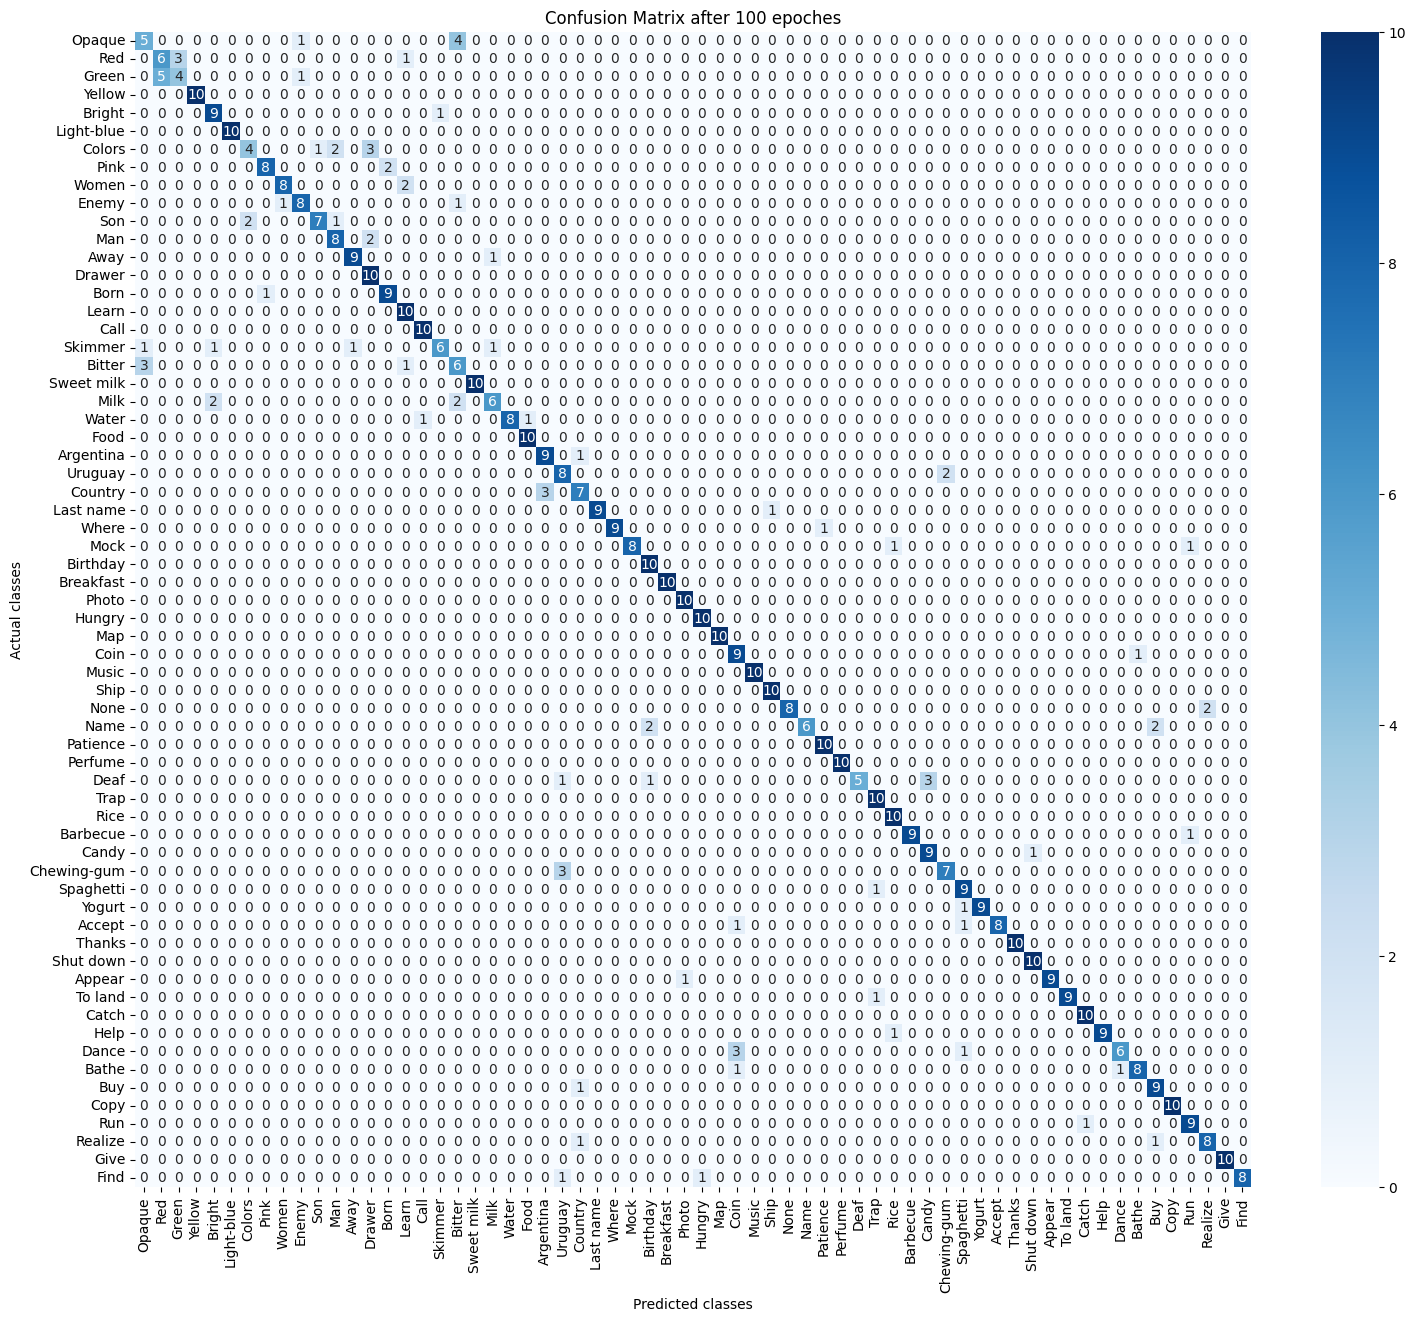

In [59]:
model= LstmModel(lsa64class_names,1662, 227, 1)
set_train_parameters(lsa40fps, lsa40fps_labels, lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)

Training Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

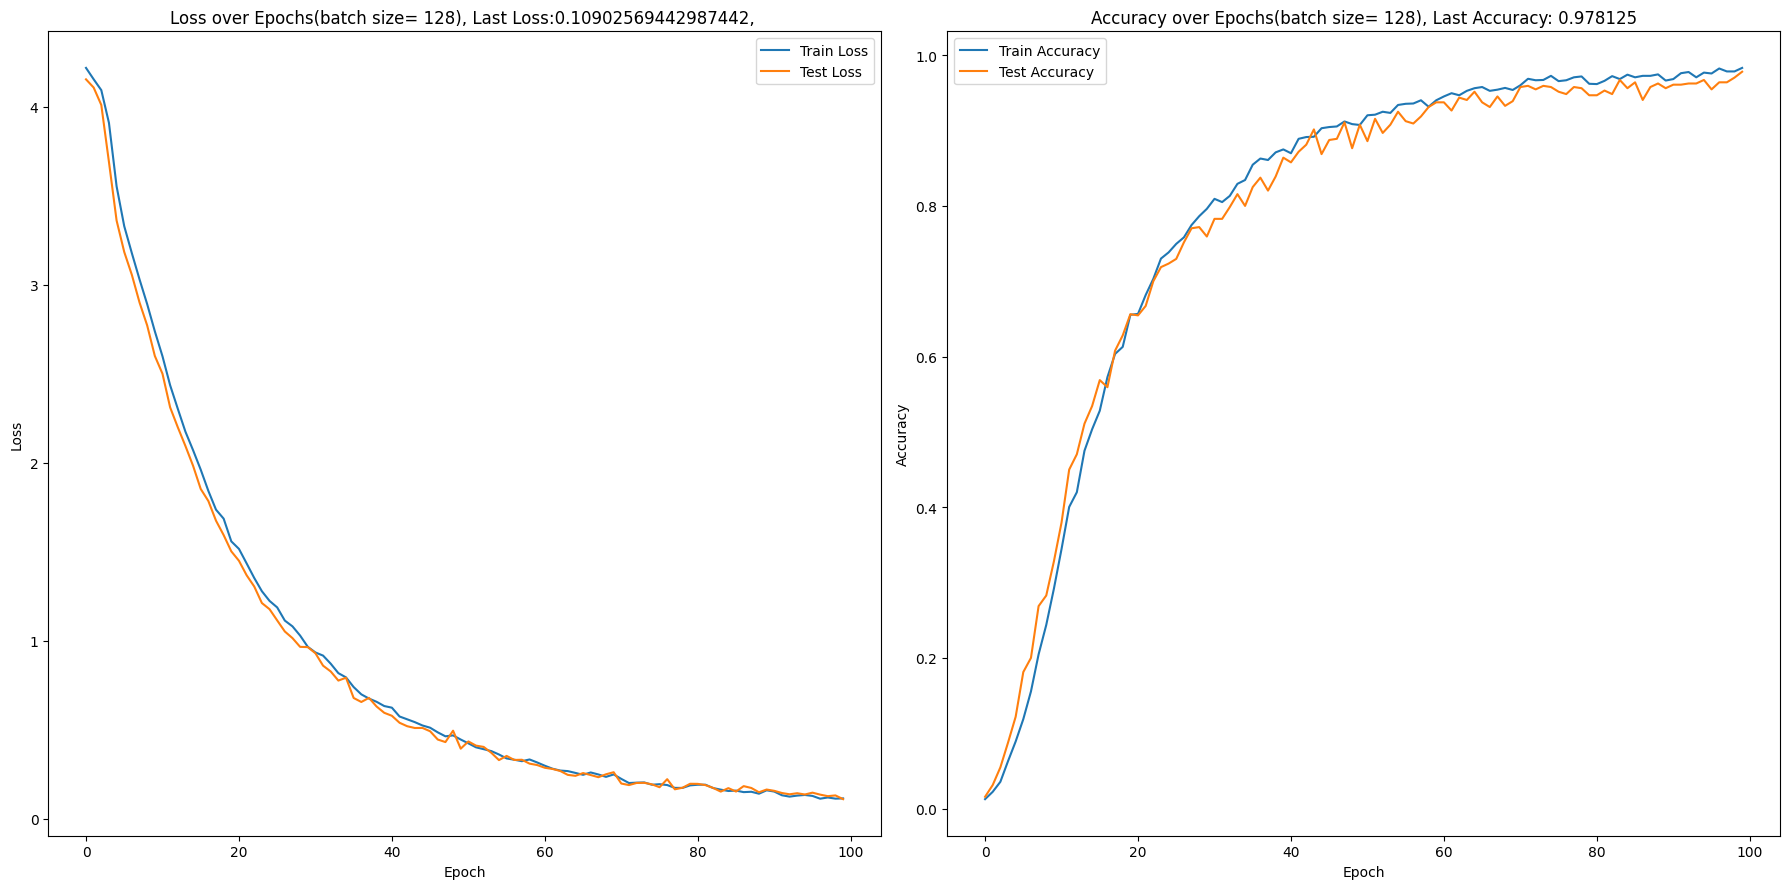

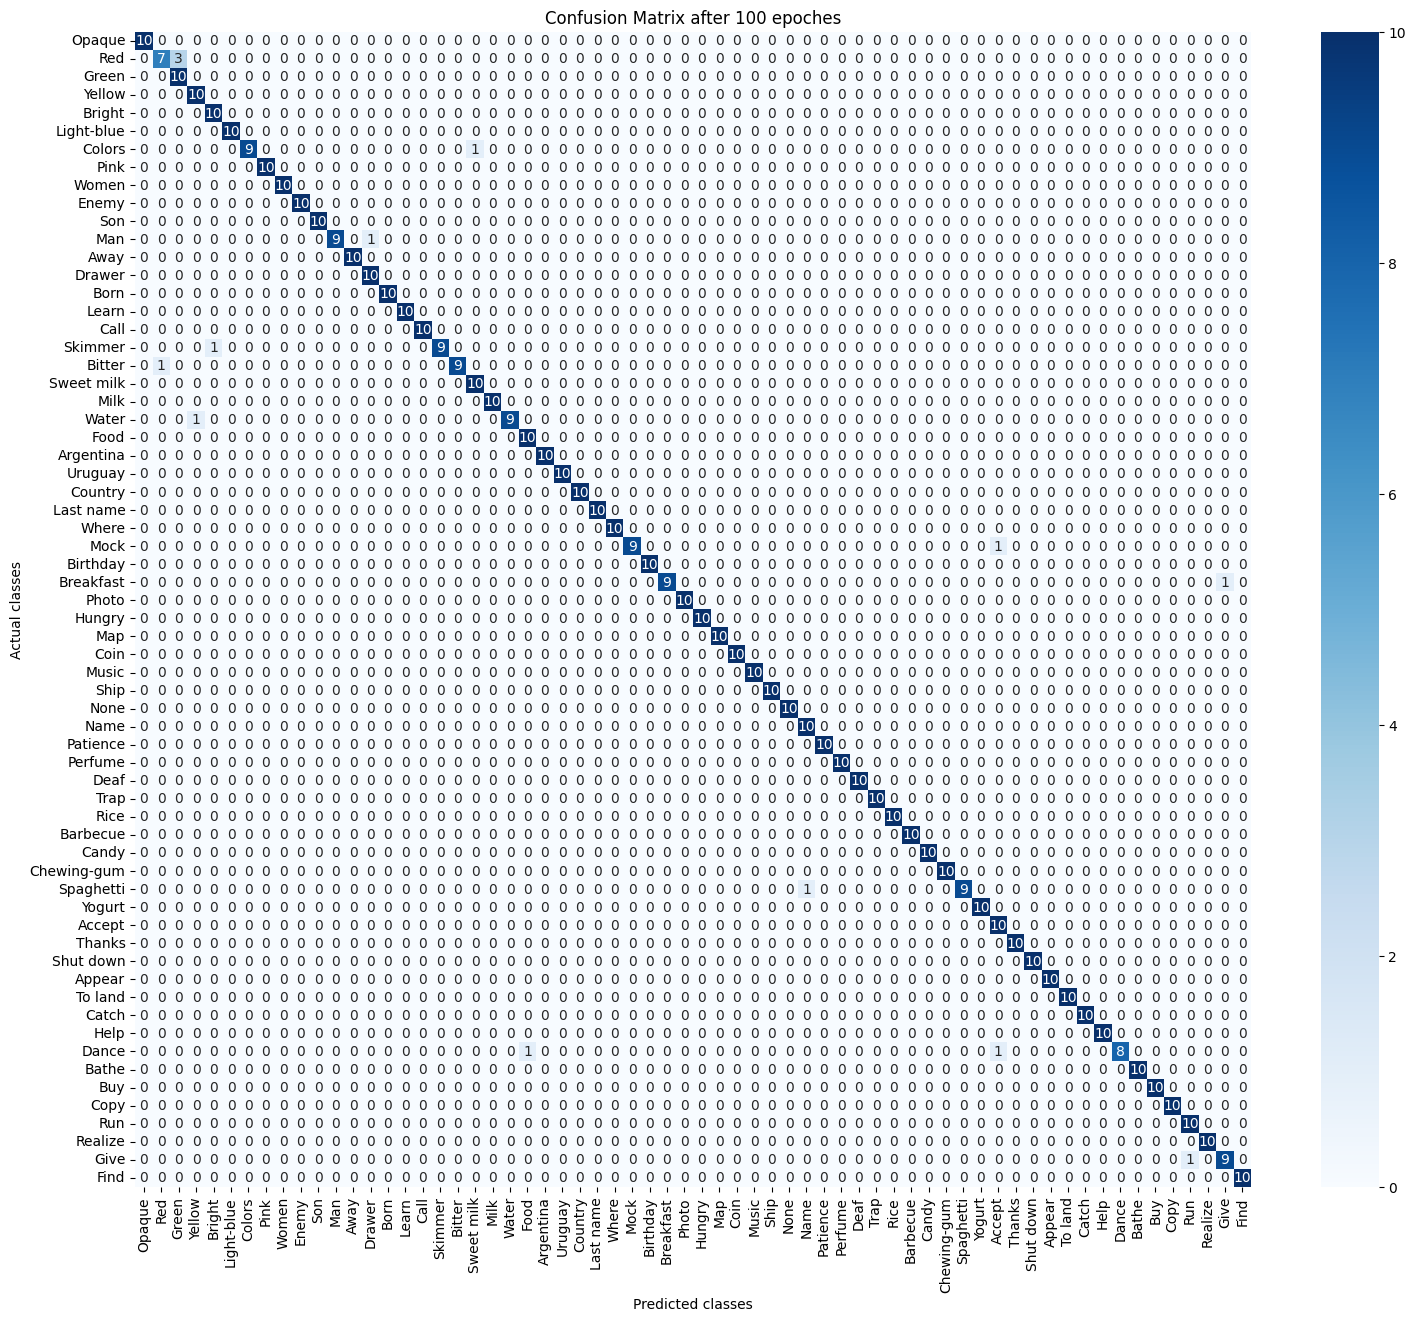

In [60]:
model= LinearParamTransformer(lsa64class_names, 40, 128, 4, 2048, 2, 1662)
set_train_parameters(lsa40fps, lsa40fps_labels, lsa64class_names, 0.2, 42, 128, 100, model, 0.0001, device)